# Passo 1: Setup do Projeto

In [40]:
import joblib
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

print('Matplot version : {}'.format(matplotlib.__version__))
print('Numpy version : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version : {}'.format(sklearn.__version__))

Matplot version : 3.3.2
Numpy version : 1.19.2
Pandas version : 1.1.3
Sklearn version : 0.23.2


# Passo 2: Recuperação dos dados

In [5]:
DATA_PATH = os.path.join('..','data','raw')
DATA_FILE = 'crx.csv'

CREDIT_DATA = os.path.join(DATA_PATH,DATA_FILE)

DEPLOY_PATH = os.path.join('..','app','model')
DEPLOY_FILE = 'finalized_model.sav'

RS = 42

In [15]:
def load_data(data_path,data_file):
    local_path = os.path.join(data_path, data_file)
    names = ['Genero','Idade','Dividas','Casado','Cliente','Escolaridade','Etnia','Anos_empregado','Padrao_anterior','Empregado','Score','Licenca','Cidadania','Codigo_postal','Renda','Resultado']
    df = pd.read_csv(local_path, header=None, names=names)
    return df[['Dividas','Anos_empregado','Padrao_anterior','Score','Renda','Resultado']]

In [16]:
credit_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3: Substituição dos dados

In [17]:
pd.unique(credit_data['Padrao_anterior'])

array(['t', 'f'], dtype=object)

In [18]:
pd.unique(credit_data['Resultado'])

array(['+', '-'], dtype=object)

In [19]:
prior  = {'t':1,'f':0}
credit_data['Padrao_anterior'] = credit_data['Padrao_anterior'].map(prior)

In [21]:
res = {'+' : 1,'-' : 0}
credit_data['Resultado'] = credit_data['Resultado'].map(res)

# Passo 4: Análise Exploratória dos dados

In [22]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Dividas          690 non-null    float64
 1   Anos_empregado   690 non-null    float64
 2   Padrao_anterior  690 non-null    int64  
 3   Score            690 non-null    int64  
 4   Renda            690 non-null    int64  
 5   Resultado        690 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 32.5 KB


In [23]:
credit_data.head()

,Dividas,Anos_empregado,Padrao_anterior,Score,Renda,Resultado
0,0.000,1.25,1,1,0,1
1,4.460,3.04,1,6,560,1
2,0.500,1.50,1,0,824,1
3,1.540,3.75,1,5,3,1
4,5.625,1.71,1,0,0,1


In [24]:
credit_data.describe()

,Dividas,Anos_empregado,Padrao_anterior,Score,Renda,Resultado
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,4.758725,2.223406,0.523188,2.40000,1017.385507,0.444928
std,4.978163,3.346513,0.499824,4.86294,5210.102598,0.497318
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.165000,0.000000,0.00000,0.000000,0.000000
50%,2.750000,1.000000,1.000000,0.00000,5.000000,0.000000
75%,7.207500,2.625000,1.000000,3.00000,395.500000,1.000000
max,28.000000,28.500000,1.000000,67.00000,100000.000000,1.000000


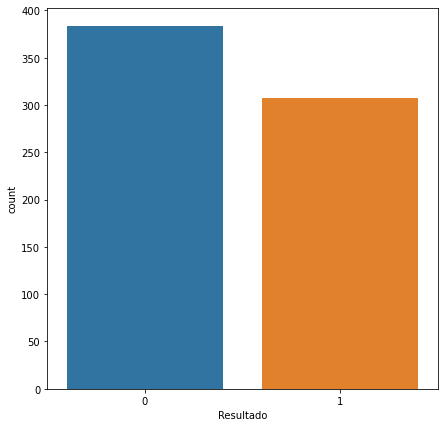

In [26]:
plt.figure(figsize=(7,7))
_ = sns.countplot(x='Resultado',data=credit_data)

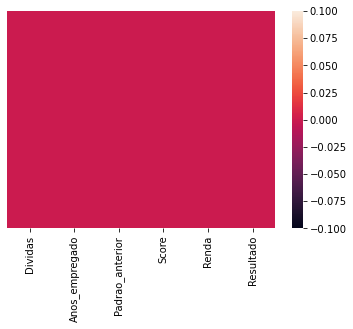

In [27]:
_ = sns.heatmap(credit_data.isnull(),yticklabels=False,cbar=True)

In [28]:
credit_data.isnull().sum()

Dividas            0
Anos_empregado     0
Padrao_anterior    0
Score              0
Renda              0
Resultado          0
dtype: int64

In [29]:
x = credit_data.drop(['Resultado'],axis=1)
y = credit_data['Resultado']

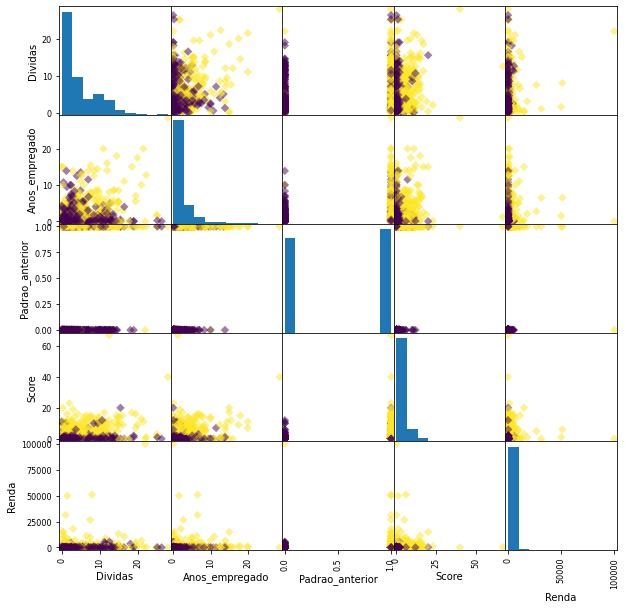

In [30]:
_ = pd.plotting.scatter_matrix(x, c=y, figsize=[10,10], marker='D')

# Passo 5: Preparação de Dados

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(x))
X_scaled.columns = x.columns

# Passo 6: Treinamento do modelo

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, stratify=y, random_state=RS)

In [37]:
def build_classifiers():
    
    classifiers = []
    classifiers.append(
        ('knn',
        KNeighborsClassifier(),
        {'n_neighbors': range(1, 33, 2)})
    )
    
    classifiers.append(
        ('lr',
        LogisticRegression(max_iter=1000),
        {'penalty': ['l2'], 'C': [100,10,1, 0.1,0.01]})
    )
    
    classifiers.append(
        ('svm',
        SVC(),
        {'C': [2**(-5),1,2**5,2**10],
        'gamma': [2**(-15),2**(-10),2**(-5),1, 2**5]})
    )
    
    classifiers.append(
        ('dt',
        DecisionTreeClassifier(),
        {'max_depth': [2,4,6,8,10,12]})
    )
    
    classifiers.append(
        ('rf',
        RandomForestClassifier(),
        {'n_estimators': [10,50,100]})
    )
    
    classifiers.append(
        ('gpc',                              
        GaussianProcessClassifier(), 
        {'kernel':[1.0 * RBF(1.0)]})   
    )
    
    return classifiers

In [38]:
classifiers = build_classifiers()

In [41]:
results = []
names = []
for name, model, parameters in classifiers:
    print(">> classifier name: {}".format(name))
    gs = GridSearchCV(estimator=model,param_grid=parameters,refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state=RS)
    cv = cross_val_score(gs, x_train, y_train, cv=kf, scoring='accuracy')
    print('Mean: {}, Standart Deviation: {}'.format(cv.mean(),cv.std()))
    results.append(cv)
    names.append(name)

>> classifier name: knn
Mean: 0.8280187074829932, Standart Deviation: 0.04781008584983387
>> classifier name: lr
Mean: 0.8321003401360544, Standart Deviation: 0.04273729074040258
>> classifier name: svm
Mean: 0.8280187074829932, Standart Deviation: 0.03667384514594678
>> classifier name: dt
Mean: 0.8154336734693878, Standart Deviation: 0.06989993759303512
>> classifier name: rf
Mean: 0.8321428571428573, Standart Deviation: 0.03715402591167872
>> classifier name: gpc
Mean: 0.8239795918367347, Standart Deviation: 0.03986907485981133


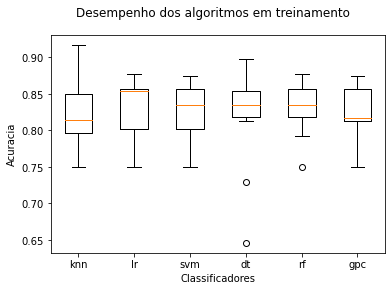

In [42]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em treinamento')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acuracia')
plt.show()

# Passo 7: Testar o Modelo

In [43]:
classifiers = build_classifiers()
test_results = []
names = []

for name, model, parameters in classifiers:
    gs = GridSearchCV(estimator=model,param_grid=parameters, refit=True, verbose=0)
    gs.fit(x_train,y_train)
    y_pred = gs.predict(x_test)
    test_accuracy = gs.score(x_test, y_test)
    print("Acurácia do modelo {} em Teste: {}".format(name,test_accuracy))
    print(classification_report(y_test,y_pred))
    names.append(name)
    test_results.append(test_accuracy)

Acurácia do modelo knn em Teste: 0.855072463768116
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       115
           1       0.86      0.80      0.83        92

    accuracy                           0.86       207
   macro avg       0.86      0.85      0.85       207
weighted avg       0.86      0.86      0.85       207

Acurácia do modelo lr em Teste: 0.9130434782608695
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       115
           1       0.84      0.99      0.91        92

    accuracy                           0.91       207
   macro avg       0.92      0.92      0.91       207
weighted avg       0.92      0.91      0.91       207

Acurácia do modelo svm em Teste: 0.9033816425120773
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       115
           1       0.85      0.96      0.90        92

    accuracy                

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


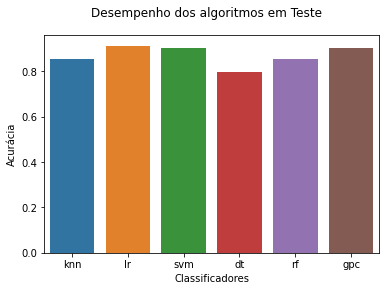

In [44]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em Teste')
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acurácia')
_ = sns.barplot(names, test_results)

In [45]:
# Considerando as informações obtidas o Classificador LogisticRegression foi que obteve melhor desempenho